In [9]:
# Gerekli Kütüphanelerin Yüklenmesi
import pandas as pd  # Veri manipülasyonu (DataFrame) için
import numpy as np   # Sayısal işlemler ve matrisler için
import matplotlib.pyplot as plt # Grafik çizimi için temel kütüphane
import seaborn as sns # Gelişmiş görselleştirme kütüphanesi
from sklearn.model_selection import train_test_split # Veriyi eğitim/test olarak ayırmak için
from sklearn.preprocessing import LabelEncoder, StandardScaler # Etiket kodlama ve Ölçeklendirme
from IPython.display import display

# Görselleştirme ayarı
sns.set_style("whitegrid") # Grafiklerin arka planını ızgaralı beyaz yapar

Veri Seti Boyutu: (13028, 69)


C:\Users\user\AppData\Local\Temp\ipykernel_5308\376389725.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Kingdom', data=df, order=df['Kingdom'].value_counts().index, palette='viridis') # 'Kingdom' sütununun değer sayım grafiğini çiz


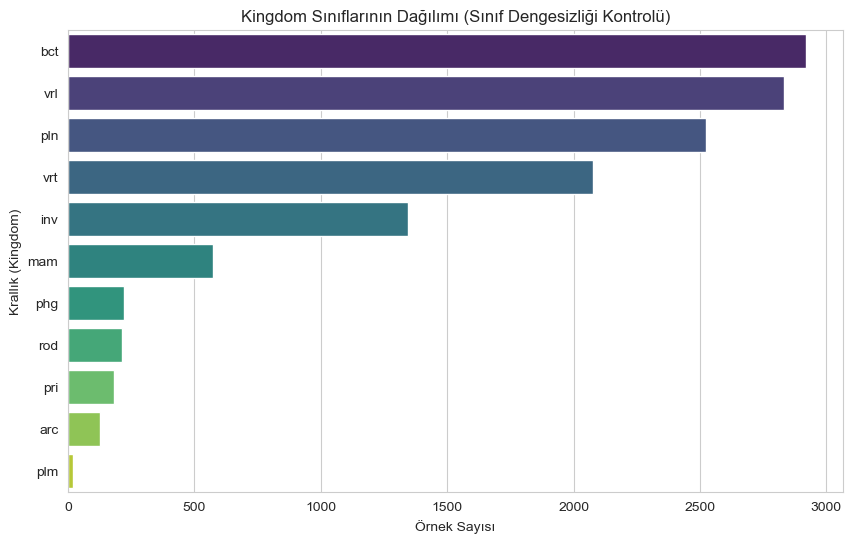

,Kingdom,DNAtype,SpeciesID,Ncodons,SpeciesName,UUU,UUC,UUA,UUG,CUU,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA;
0,vrl,0,100217,1995,Epizootic haematopoietic necrosis virus,0.01654,0.01203,0.00050,0.00351,0.01203,...,0.00451,0.01303,0.03559,0.01003,0.04612,0.01203,0.04361,0.00251,0.00050,0;
1,vrl,0,100220,1474,Bohle iridovirus,0.02714,0.01357,0.00068,0.00678,0.00407,...,0.00136,0.01696,0.03596,0.01221,0.04545,0.01560,0.04410,0.00271,0.00068,0;
2,vrl,0,100755,4862,Sweet potato leaf curl virus,0.01974,0.0218,0.01357,0.01543,0.00782,...,0.00596,0.01974,0.02489,0.03126,0.02036,0.02242,0.02468,0.00391,0.00000,0.00144;
3,vrl,0,100880,1915,Northern cereal mosaic virus,0.01775,0.02245,0.01619,0.00992,0.01567,...,0.00366,0.01410,0.01671,0.03760,0.01932,0.03029,0.03446,0.00261,0.00157,0;
4,vrl,0,100887,22831,Soil-borne cereal mosaic virus,0.02816,0.01371,0.00767,0.03679,0.01380,...,0.00604,0.01494,0.01734,0.04148,0.02483,0.03359,0.03679,0.00000,0.00044,0.00131;


In [10]:
## Veri seti dosyadan (codon_usage.csv) yükleniyor.
# Ardından veri setinin boyutu (satır, sütun) yazdırılıyor ve 'Kingdom' (Krallık) sınıf dağılımı görselleştiriliyor (Sınıf dengesizliği kontrolü). 

df = pd.read_csv(r"C:\\Users\\user\\Documents\\2025-2026 Ders Notları\\Veri Madenciliği\\Güz Dönemi\\CodonUsageProject\\data\\codon_usage.csv", low_memory=False)

print("Veri Seti Boyutu:", df.shape) # Yüklenen veri setinin boyutunu göster

plt.figure(figsize=(10, 6)) # Yeni bir çizim figürü oluştur
sns.countplot(y='Kingdom', data=df, order=df['Kingdom'].value_counts().index, palette='viridis') # 'Kingdom' sütununun değer sayım grafiğini çiz
plt.title('Kingdom Sınıflarının Dağılımı (Sınıf Dengesizliği Kontrolü)') # Başlık
plt.xlabel('Örnek Sayısı') # X ekseni etiketi
plt.ylabel('Krallık (Kingdom)') # Y ekseni etiketi
plt.show() 

display(df.head()) # Veri setinin ilk 5 satırını göster

In [11]:
# Özellik tanımlamaları yapılıyor. Kodon (UUU, UUC, vb.), 'Ncodons' ve 'DNAtype' sütunları sayısal özellikler olarak belirleniyor.
# Ardından, sayısal olması gereken sütunlarda ondalık ayracı olarak kullanılan virgüller (,) noktaya (.) çevriliyor ve sütunlar sayısal tipe zorlanıyor.
# Son olarak, modelleme için gereksiz olan 'SpeciesID' ve 'SpeciesName' sütunları veri setinden çıkarılıyor.

codon_cols = df.columns[5:] # Kodon frekans sütunlarını seç
other_numeric_cols = ['Ncodons', 'DNAtype'] # Diğer sayısal sütunlar
numeric_features = list(codon_cols) + other_numeric_cols # Tüm sayısal özellik listesi

print("--- 3. Temizlik Başlangıç (Virgül -> Nokta) ---") 
for col in numeric_features: # Sayısal olması gereken her sütun için döngü
    if df[col].dtype == 'object': # Sütun tipi 'object' (string) ise
       
        df[col] = pd.to_numeric(
            df[col].astype(str).str.replace(",", ".", regex=False), # Virgülleri noktaya çevir
            errors="coerce" # Dönüşüm hatası olursa NaN yap
        )

df_cleaned = df.drop(columns=['SpeciesID', 'SpeciesName']).copy() # Gereksiz sütunları sil ve kopyala

--- 3. Temizlik Başlangıç (Virgül -> Nokta) ---


In [12]:
# Biyolojik bir özellik olan GC Oranı (Guanin ve Sitozin içeriği) hesaplanarak yeni bir öznitelik (GC_Content) türetiliyor.
# Bu, her bir türün kodon frekansları kullanılarak GC oranının yaklaşık bir tahmini olarak hesaplanır.

def calculate_gc_content(row): # GC içeriği hesaplama fonksiyonu
    gc_score = 0 # GC skoru sıfırla
    for codon in codon_cols: # Her bir kodon için döngü
        gc_count = codon.count('G') + codon.count('C') # Kodondaki G ve C sayısını bul
        gc_score += row[codon] * gc_count # Frekans * G/C sayısını topla
        
    return gc_score / 3 # Skoru 3'e bölerek normalize et

print("Yeni özellik 'GC_Content' hesaplanıyor... (Biraz sürebilir)") # Hesaplama mesajı
df_cleaned['GC_Content'] = df_cleaned.apply(calculate_gc_content, axis=1) # Fonksiyonu her satıra uygula

print("İşlem Tamam! Yeni veri setinin boyutu:", df_cleaned.shape) # Yeni boyutu göster
print("Örnek GC Oranları:") # Örnek GC oranları mesajı
print(df_cleaned[['GC_Content']].head()) # İlk 5 GC_Content değerini göster

Yeni özellik 'GC_Content' hesaplanıyor... (Biraz sürebilir)
İşlem Tamam! Yeni veri setinin boyutu: (13028, 68)
Örnek GC Oranları:
   GC_Content
0         NaN
1         NaN
2         NaN
3         NaN
4         NaN


In [13]:
# Veri seti, 'Kingdom' hedef değişkenine göre katmanlı (stratified) bir şekilde %80 eğitim (train) ve %20 test (test) olarak ikiye ayrılıyor.
# Bu ayrım, her bir krallık sınıfının oranının hem eğitim hem de test setinde korunmasını sağlar.

X = df_cleaned.drop(columns=['Kingdom']) # Özellikler (kodon frekansları, vb.)
y = df_cleaned['Kingdom'] # Hedef değişken (Krallık)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y # Stratify=y ile sınıf oranlarını koru
)

train_df = pd.concat([X_train, y_train], axis=1) # Eğitim setini birleştir
test_df = pd.concat([X_test, y_test], axis=1) # Test setini birleştir

print("\n--- Veri Ayırma Sonuçları ---") 
print(f"X_train Boyutu: {X_train.shape}") # Eğitim özellik seti boyutunu yazdır
print(f"X_test Boyutu: {X_test.shape}") # Test özellik seti boyutunu yazdır


--- Veri Ayırma Sonuçları ---
X_train Boyutu: (10422, 67)
X_test Boyutu: (2606, 67)


In [14]:
# KONTAMİNASYONU ENGELLEYEN İŞLEM SIRASI:
# 1. Eksik Değer Doldurma (Imputation): Test setindeki eksik değerler bile, sadece eğitim setinin ortalaması kullanılarak doldurulur.
# 2. Kategorik Hedef Değişken Kodlama (Encoding): 'Kingdom' etiketleri (arc, bct, vb.) sayısal değerlere dönüştürülür.
# 3. Özellik Ölçeklendirme (Scaling): Sayısal özellikler, eğitim setine göre standartlaştırılarak (StandardScaler) makine öğrenimi modeline hazır hale getirilir.

train_means = train_df[numeric_features].mean() # Eğitim setindeki ortalamaları hesapla

train_df[numeric_features] = train_df[numeric_features].fillna(train_means) # Eğitim setini doldur
test_df[numeric_features] = test_df[numeric_features].fillna(train_means) # Test setini doldur

print("\nEksik Değer Doldurma Tamamlandı (Test seti, Train ortalaması ile dolduruldu).") 

le = LabelEncoder() # LabelEncoder nesnesi oluştur
train_df['Kingdom_Encoded'] = le.fit_transform(train_df['Kingdom']) # Eğitim etiketlerini kodla (fit ve transform)
test_df['Kingdom_Encoded'] = le.transform(test_df['Kingdom']) # Test etiketlerini kodla (sadece transform)

print("Krallık Kodlaması:", dict(zip(le.classes_, le.transform(le.classes_)))) # Kodlama haritasını göster

scaler = StandardScaler() # StandardScaler nesnesi oluştur

scaler.fit(train_df[numeric_features]) # Ölçekleyiciyi eğitim setine fit et

train_df[numeric_features] = scaler.transform(train_df[numeric_features]) # Eğitim setini dönüştür
test_df[numeric_features] = scaler.transform(test_df[numeric_features]) # Test setini dönüştür

print("Ölçeklendirme Tamamlandı (Ncodons ve Kodonlar Standardize Edildi).") 


Eksik Değer Doldurma Tamamlandı (Test seti, Train ortalaması ile dolduruldu).
Krallık Kodlaması: {'arc': np.int64(0), 'bct': np.int64(1), 'inv': np.int64(2), 'mam': np.int64(3), 'phg': np.int64(4), 'plm': np.int64(5), 'pln': np.int64(6), 'pri': np.int64(7), 'rod': np.int64(8), 'vrl': np.int64(9), 'vrt': np.int64(10)}
Ölçeklendirme Tamamlandı (Ncodons ve Kodonlar Standardize Edildi).


In [15]:
# Tüm ön işleme adımları (imputation, encoding, scaling) tamamlandıktan sonra, makine öğrenimi modellerini eğitmek ve test etmek için kullanılacak nihai X_train, y_train, X_test ve y_test veri setleri oluşturuluyor.
# Bu nihai setler, gelecekteki modelleme çalışmalarını kolaylaştırmak için CSV dosyaları olarak kaydediliyor.


X_train_final = train_df.drop(columns=['Kingdom', 'Kingdom_Encoded']) # Eğitim özellikleri
y_train_final = train_df['Kingdom_Encoded'] # Eğitim etiketleri (kodlanmış)
X_test_final = test_df.drop(columns=['Kingdom', 'Kingdom_Encoded']) # Test özellikleri
y_test_final = test_df['Kingdom_Encoded'] # Test etiketleri (kodlanmış)

X_train_final.to_csv('X_train_final_KUSURSUZ.csv', index=False) # X_train'i kaydet
X_test_final.to_csv('X_test_final_KUSURSUZ.csv', index=False) # X_test'i kaydet
pd.DataFrame({'Kingdom_Encoded': y_train_final.values, 'Kingdom_Original': train_df['Kingdom'].values}).to_csv('y_train_encoded_final_KUSURSUZ.csv', index=False) # y_train'i kaydet
pd.DataFrame({'Kingdom_Encoded': y_test_final.values, 'Kingdom_Original': test_df['Kingdom'].values}).to_csv('y_test_encoded_final_KUSURSUZ.csv', index=False) # y_test'i kaydet

print("\n--- TEBRİKLER! ---")
print("Tüm hazırlık adımları tamamlandı. Verileriniz 'KUSURSUZ' etiketli dosyalara kaydedilmiştir. ✅") 




--- TEBRİKLER! ---
Tüm hazırlık adımları tamamlandı. Verileriniz 'KUSURSUZ' etiketli dosyalara kaydedilmiştir. ✅


Güvenlik temizliği yapıldı. NaN kontrolü:  0

--- SEÇİLEN EN İYİ 20 KODON ---
['DNAtype', 'UUC', 'UUG', 'CUC', 'CUA', 'AUC', 'GCG', 'CCA', 'CCG', 'UGG', 'ACC', 'ACA', 'ACG', 'UGU', 'AAG', 'CGU', 'CGC', 'AGA', 'AGG', 'GAU']


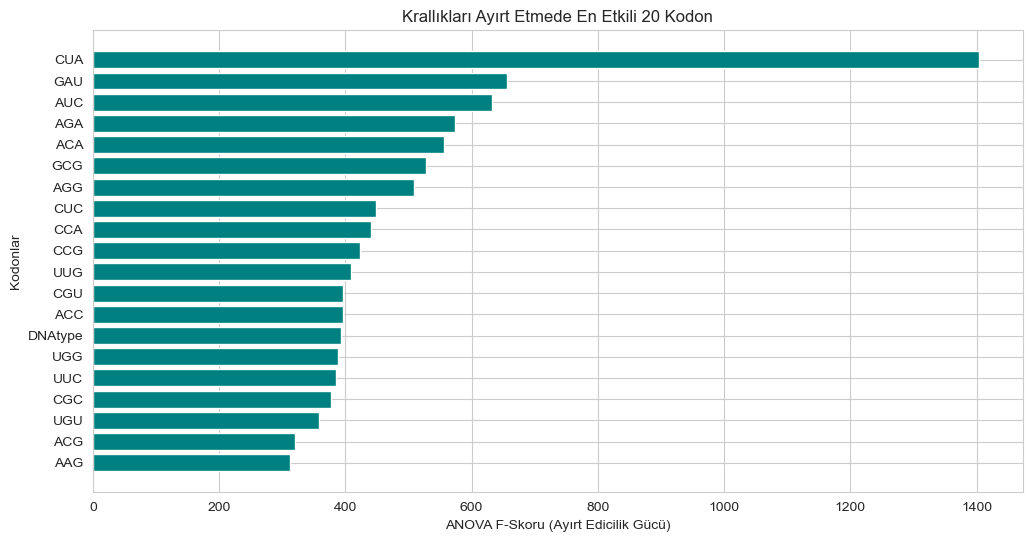

In [16]:
## ANOVA F-Skoru (f_classif) kullanılarak hedef değişkeni (Krallık) en iyi ayırt eden 20 öznitelik (kodon/özellik) seçiliyor (SelectKBest).
# Öznitelik seçimi, modelin gereksiz gürültüden arındırılması ve eğitim süresinin azaltılması için bir boyut indirgeme yöntemidir.

from sklearn.feature_selection import SelectKBest, f_classif # Öznitelik seçimi için kütüphaneler
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean') # Eksik değerleri ortalama ile dolduracak nesne

X_train_final = pd.DataFrame(imputer.fit_transform(X_train_final), columns=X_train_final.columns) # Eğitim setini doldur ve DataFrame yap
X_test_final = pd.DataFrame(imputer.transform(X_test_final), columns=X_test_final.columns) # Test setini doldur ve DataFrame yap

print("Güvenlik temizliği yapıldı. NaN kontrolü: ", X_train_final.isnull().sum().sum()) # NaN kontrolü


k_best_selector = SelectKBest(score_func=f_classif, k=20) # En iyi 20 özelliği seçecek nesne
X_train_selected = k_best_selector.fit_transform(X_train_final, y_train_final) # Eğitim setini fit et/dönüştür
X_test_selected = k_best_selector.transform(X_test_final) # Test setini dönüştür

selected_indices = k_best_selector.get_support(indices=True) # Seçilen özelliklerin indekslerini al
selected_features = X_train_final.columns[selected_indices] # Seçilen özellik isimlerini al

print(f"\n--- SEÇİLEN EN İYİ 20 KODON ---")
print(selected_features.tolist()) # Seçilen özellik listesini yazdır

scores = k_best_selector.scores_ # F-skorlarını al
feature_scores = pd.DataFrame({'Feature': X_train_final.columns, 'Score': scores}) # Skorları DataFrame'e dönüştür
feature_scores = feature_scores.sort_values(by='Score', ascending=False).head(20) # En yüksek 20 skoru al

plt.figure(figsize=(12, 6)) # Yeni çizim figürü
plt.barh(feature_scores['Feature'], feature_scores['Score'], color='teal') # Yatay çubuk grafik çiz
plt.xlabel('ANOVA F-Skoru (Ayırt Edicilik Gücü)') # X ekseni etiketi
plt.ylabel('Kodonlar') 
plt.title('Krallıkları Ayırt Etmede En Etkili 20 Kodon') 
plt.gca().invert_yaxis() # Y eksenini ters çevir
plt.show() 

--- PCA SONUÇLARI ---
Orijinal Özellik Sayısı: 67
PCA Sonrası Bileşen Sayısı: 43
Korunan Toplam Varyans Oranı: %95.01


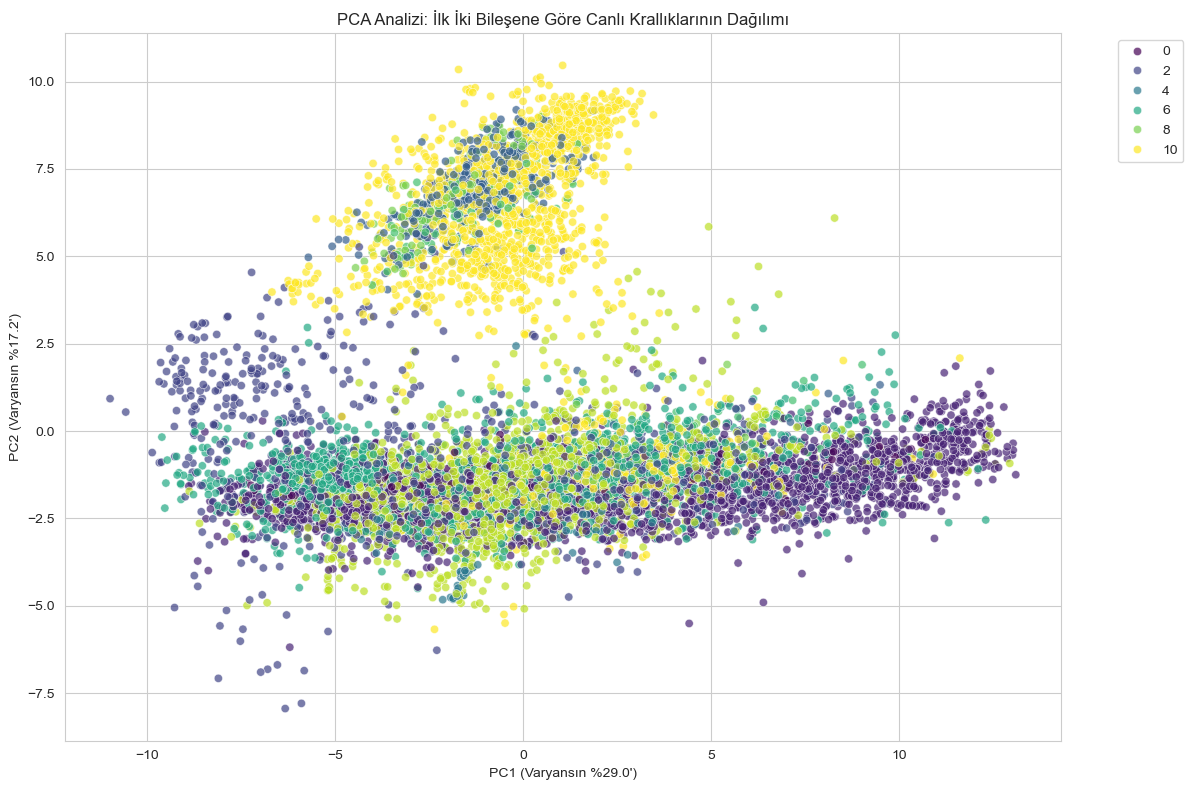

In [17]:
## Temel Bileşen Analizi (PCA) kullanılarak veri setindeki varyansın (bilginin) %95'ini koruyacak kadar bileşen sayısı (43) belirleniyor ve veri bu yeni boyutlu uzaya indirgeniyor.
# Ayrıca ilk iki Temel Bileşen (PC1 ve PC2) kullanılarak krallıkların 2 boyutlu uzayda nasıl kümelendiği görselleştiriliyor.

from sklearn.decomposition import PCA # PCA kütüphanesi

pca = PCA(n_components=0.95) # %95 varyansı koruyacak PCA nesnesi
X_train_pca = pca.fit_transform(X_train_final) # Eğitim setini fit et/dönüştür
X_test_pca = pca.transform(X_test_final) # Test setini dönüştür

print(f"--- PCA SONUÇLARI ---") 
print(f"Orijinal Özellik Sayısı: {X_train_final.shape[1]}") 
print(f"PCA Sonrası Bileşen Sayısı: {X_train_pca.shape[1]}") 
print(f"Korunan Toplam Varyans Oranı: %{pca.explained_variance_ratio_.sum() * 100:.2f}") # Korunan varyans oranı

plt.figure(figsize=(12, 8)) # Yeni çizim figürü

pca_df = pd.DataFrame(data=X_train_pca[:, :2], columns=['PC1', 'PC2']) # İlk 2 PC ile DataFrame oluştur
pca_df['Kingdom'] = y_train_final.values

sns.scatterplot(x='PC1', y='PC2', hue='Kingdom', data=pca_df, palette='viridis', alpha=0.7) # Dağılım grafiği çiz
plt.title('PCA Analizi: İlk İki Bileşene Göre Canlı Krallıklarının Dağılımı') 
plt.xlabel(f'PC1 (Varyansın %{pca.explained_variance_ratio_[0]*100:.1f}\')') # PC1 eksen etiketi
plt.ylabel(f'PC2 (Varyansın %{pca.explained_variance_ratio_[1]*100:.1f}\')') # PC2 eksen etiketi
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') 
plt.tight_layout() 
plt.show() 

In [18]:
# Sadece Karar Ağacı (Decision Tree) ile Karşılaştırmalı Analiz 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score # f1_score eklendi
import time

#random_state=42 ile sabitledik.
models = {
    "Karar Ağacı (Decision Tree)": DecisionTreeClassifier(random_state=42)
}

#Veri Seti Senaryolarını Tanımlayalım 
datasets = {
    "1. Ham Veri (Tüm Özellikler)": (X_train_final, X_test_final),
    "2. ANOVA ile Seçilmiş (Top-20)": (X_train_selected, X_test_selected),
    "3. PCA ile İndirgenmiş (PCA)": (X_train_pca, X_test_pca)
}

results = []  # Sonuç listesi

print("--- KARAR AĞACI ANALİZ SÜRECİ BAŞLADI ---")

for data_name, (X_tr, X_te) in datasets.items():    # Her veri seti senaryosu için döngü
    print(f"\n>> Veri Seti: {data_name} üzerinde çalışılıyor...")
    
    for model_name, model in models.items():
        start_time = time.time()     # Başlangıç zamanı
        model.fit(X_tr, y_train_final)  # Modeli eğit
        y_pred = model.predict(X_te)    # Tahmin Et
        elapsed_time = time.time() - start_time # Süreyi bitir
        
        # Metrikleri Hesapla (Accuracy ve F1 Score)
        # Sınıf dengesizliği olduğu için average='weighted' kullanıldı
        acc = accuracy_score(y_test_final, y_pred)
        f1 = f1_score(y_test_final, y_pred, average='weighted')
        
        # Sonuçları kaydet
        results.append({
            "Veri Seti": data_name,
            "Model": model_name,
            "Başarı (Accuracy)": acc,
            "F1 Skoru": f1,              
            "Eğitim Süresi (sn)": elapsed_time,
            "Özellik/Bileşen Sayısı": X_tr.shape[1]
        })
        print(f"   -> Başarı: %{acc*100:.2f} | F1: %{f1*100:.2f} | Süre: {elapsed_time:.4f} sn")

# --- SONUÇ TABLOSU ---
results_df = pd.DataFrame(results)
print("\n--- NİHAİ KARŞILAŞTIRMA TABLOSU (Sadece Karar Ağacı) ---")
# Tabloyu başarı oranına göre sıralayalım
display(results_df.sort_values(by="Başarı (Accuracy)", ascending=False))

print("\n--- Detaylı Sınıflandırma Raporu (Ham Veri Üzerinden) ---")
dt_final = DecisionTreeClassifier(random_state=42)
dt_final.fit(X_train_final, y_train_final)
y_pred_final = dt_final.predict(X_test_final)

target_names = ['arc', 'bct', 'inv', 'mam', 'phg', 'plm', 'pln', 'pri', 'rod', 'vrl', 'vrt']    # Sınıf isimleri 
print(classification_report(y_test_final, y_pred_final, target_names=target_names))

--- KARAR AĞACI ANALİZ SÜRECİ BAŞLADI ---

>> Veri Seti: 1. Ham Veri (Tüm Özellikler) üzerinde çalışılıyor...
   -> Başarı: %79.01 | F1: %78.94 | Süre: 3.6575 sn

>> Veri Seti: 2. ANOVA ile Seçilmiş (Top-20) üzerinde çalışılıyor...
   -> Başarı: %74.83 | F1: %74.87 | Süre: 0.8934 sn

>> Veri Seti: 3. PCA ile İndirgenmiş (PCA) üzerinde çalışılıyor...
   -> Başarı: %78.24 | F1: %78.17 | Süre: 2.7870 sn

--- NİHAİ KARŞILAŞTIRMA TABLOSU (Sadece Karar Ağacı) ---


,Veri Seti,Model,Başarı (Accuracy),F1 Skoru,Eğitim Süresi (sn),Özellik/Bileşen Sayısı
0,1. Ham Veri (Tüm Özellikler),Karar Ağacı (Decision Tree),0.790100,0.789416,3.657533,67
2,3. PCA ile İndirgenmiş (PCA),Karar Ağacı (Decision Tree),0.782425,0.781717,2.786980,43
1,2. ANOVA ile Seçilmiş (Top-20),Karar Ağacı (Decision Tree),0.748273,0.748671,0.893441,20



--- Detaylı Sınıflandırma Raporu (Ham Veri Üzerinden) ---
              precision    recall  f1-score   support

         arc       0.35      0.24      0.29        25
         bct       0.88      0.89      0.88       584
         inv       0.58      0.61      0.59       269
         mam       0.74      0.66      0.69       114
         phg       0.53      0.45      0.49        44
         plm       0.67      0.50      0.57         4
         pln       0.81      0.78      0.79       505
         pri       0.48      0.58      0.53        36
         rod       0.59      0.63      0.61        43
         vrl       0.81      0.85      0.83       567
         vrt       0.87      0.86      0.86       415

    accuracy                           0.79      2606
   macro avg       0.66      0.64      0.65      2606
weighted avg       0.79      0.79      0.79      2606



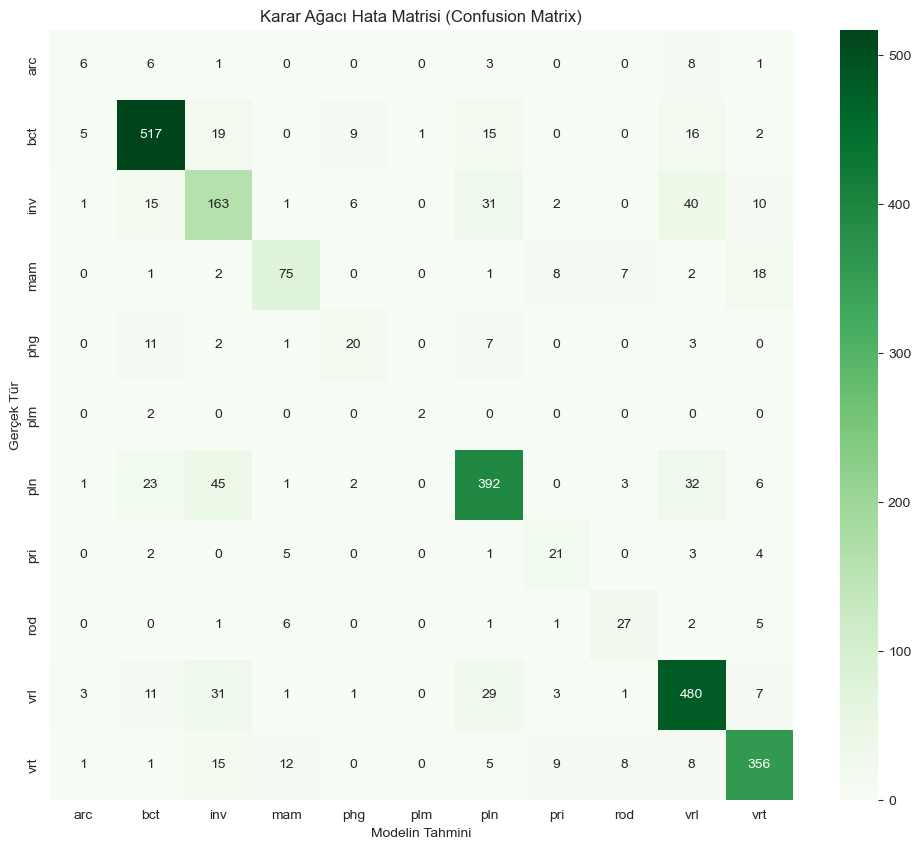

In [19]:
# Karar Ağacı modelinin en iyi performans gösteren "Ham Veri (Tüm Özellikler)" senaryosundaki tahmin sonuçları Hata Matrisi (Confusion Matrix) ile görselleştiriliyor.
# Bu matris, modelin hangi sınıfları doğru/yanlış tahmin ettiğini sınıf bazında gösterir. 
from sklearn.metrics import confusion_matrix

# Karar Ağacı modelini Ham Veri ile tekrar çağırıldı
final_model = DecisionTreeClassifier(random_state=42)
final_model.fit(X_train_final, y_train_final)
y_pred_final = final_model.predict(X_test_final)

target_names = ['arc', 'bct', 'inv', 'mam', 'phg', 'plm', 'pln', 'pri', 'rod', 'vrl', 'vrt']    # Sınıf isimleri

cm = confusion_matrix(y_test_final, y_pred_final)    # Hata matrisini oluştur

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",  # Heatmap çizimi
            xticklabels=target_names,   # X ekseni etiketleri
            yticklabels=target_names)   # Y ekseni etiketleri
plt.title("Karar Ağacı Hata Matrisi (Confusion Matrix)")
plt.xlabel("Modelin Tahmini")
plt.ylabel("Gerçek Tür")
plt.show()


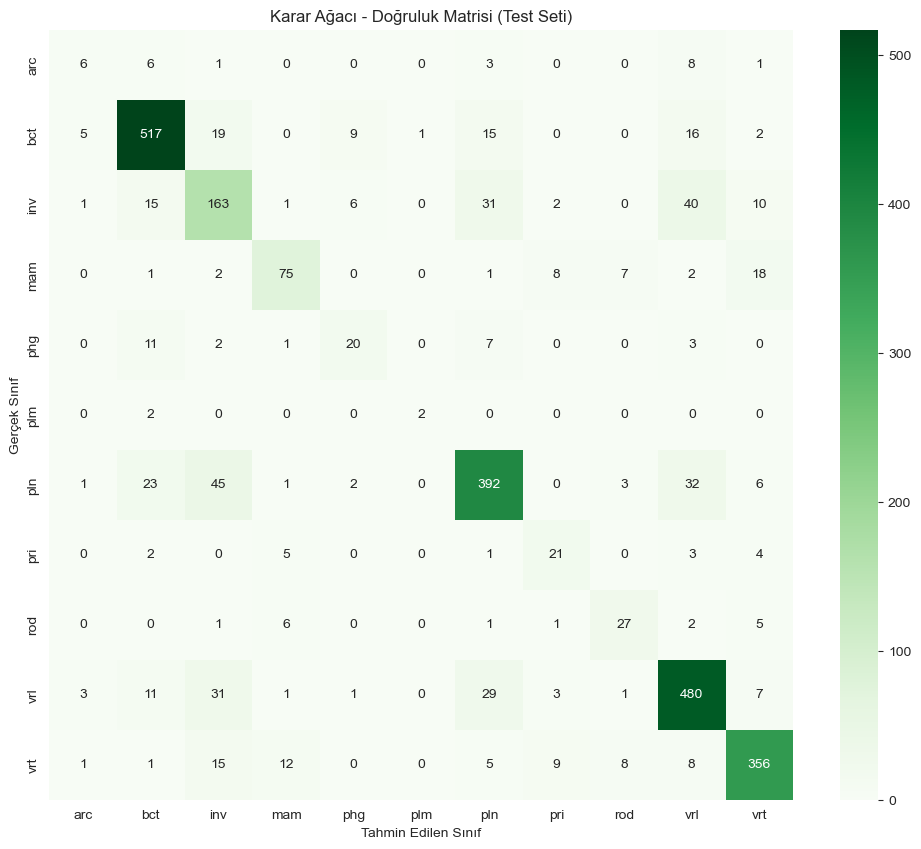

In [20]:
# Modeli Ham Veri ile tekrar kuralım
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_final, y_train_final)
y_pred_dt = dt_model.predict(X_test_final)

# Sınıf İsimleri
target_names = ['arc', 'bct', 'inv', 'mam', 'phg', 'plm', 'pln', 'pri', 'rod', 'vrl', 'vrt']

# Matrisi Oluştur
cm_dt = confusion_matrix(y_test_final, y_pred_dt)

# Görselleştir (Yeşil Tonlar)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_dt, annot=True, fmt="d", cmap="Greens", 
            xticklabels=target_names, 
            yticklabels=target_names)
plt.title("Karar Ağacı - Doğruluk Matrisi (Test Seti)")
plt.xlabel("Tahmin Edilen Sınıf")
plt.ylabel("Gerçek Sınıf")
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_5308\3057038350.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')


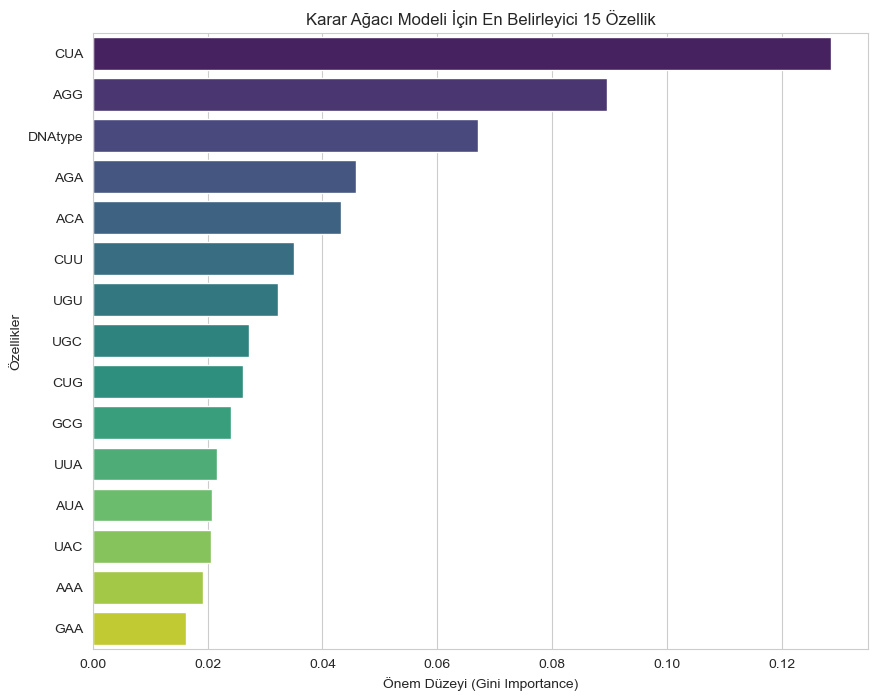

In [21]:
#Karar Ağacı modelinin hangi özelliklerin (kodonların) sınıflandırmada daha belirleyici olduğunu görselleştirmek için özellik önem düzeyleri grafiği oluşturuldu.

# Modeli tekrar çağırıldı. (Emin olmak için)
dt_final = DecisionTreeClassifier(random_state=42)
dt_final.fit(X_train_final, y_train_final)

# Özelliklerin önem skorlarını alındı.
importances = dt_final.feature_importances_
feature_names = X_train_final.columns

# Veriyi DataFrame'e çevirip sıralandı (En önemliler en üste)
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False).head(15) # İlk 15 özellik

# Çizim
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')
plt.title('Karar Ağacı Modeli İçin En Belirleyici 15 Özellik')
plt.xlabel('Önem Düzeyi (Gini Importance)')
plt.ylabel('Özellikler')
plt.show()